In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

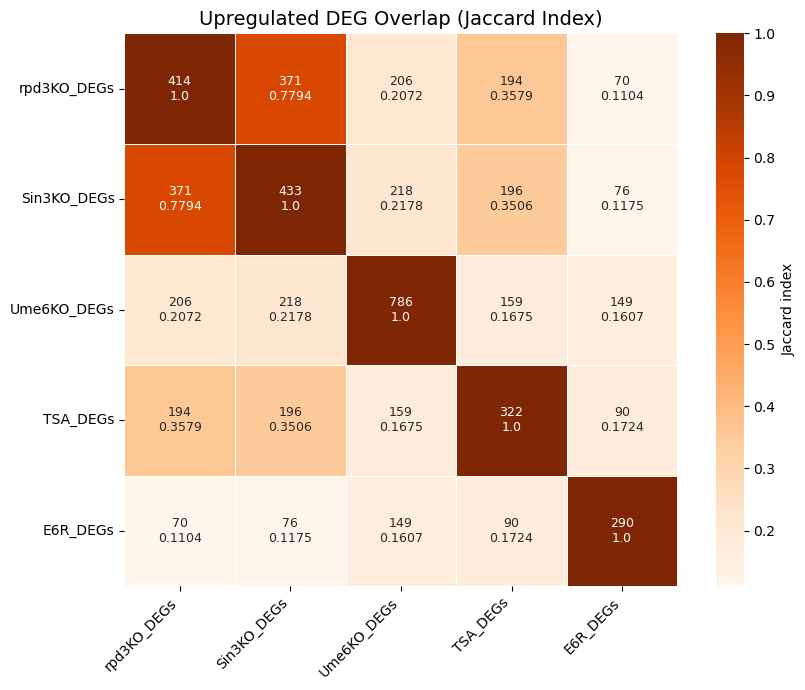

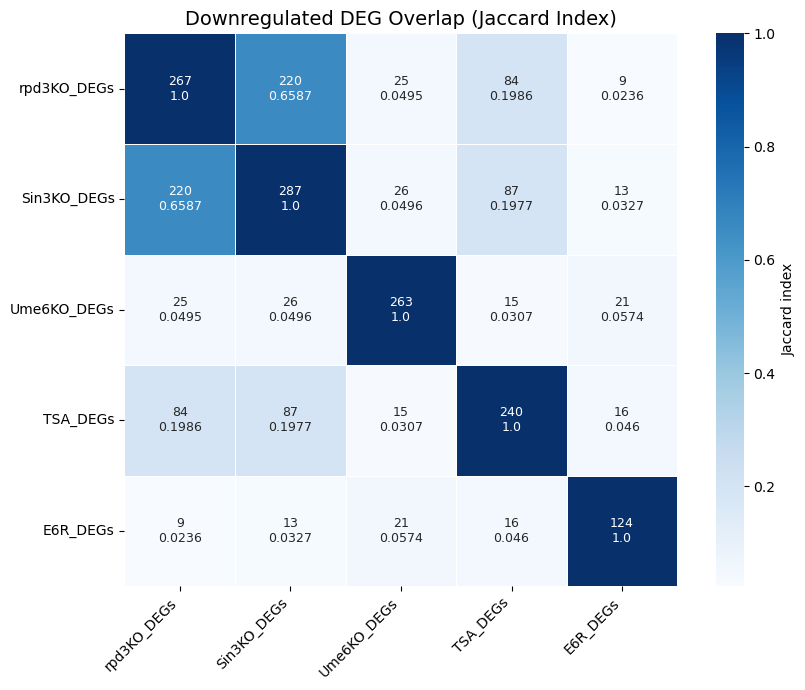

In [2]:
#Load Excel
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Prepare up & down sets
up_sets = {}
down_sets = {}

for condition, df in sheet_dict.items():
    df = df[['Systematic Name', 'log2FoldChange']].dropna()
    up_sets[condition] = set(df[df['log2FoldChange'] > 0]['Systematic Name'])
    down_sets[condition] = set(df[df['log2FoldChange'] < 0]['Systematic Name'])

def compute_jaccard_matrix(gene_sets):
    conds = list(gene_sets.keys())
    n = len(conds)
    
    overlap_matrix = pd.DataFrame(index=conds, columns=conds)
    jaccard_matrix = pd.DataFrame(index=conds, columns=conds)

    for c1 in conds:
        for c2 in conds:
            inter = gene_sets[c1] & gene_sets[c2]
            union = gene_sets[c1] | gene_sets[c2]
            overlap_matrix.loc[c1, c2] = len(inter)
            jaccard_matrix.loc[c1, c2] = len(inter) / len(union) if len(union) > 0 else 0.0

    return overlap_matrix.astype(int), jaccard_matrix.astype(float)

def plot_jaccard_heatmap(overlap, jaccard, title, cmap, filename):
    annot = overlap.astype(str) + "\n" + jaccard.round(4).astype(str)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        jaccard, 
        annot=annot, 
        fmt='', 
        cmap=cmap, 
        linewidths=0.5, 
        cbar_kws={'label': 'Jaccard index'},
        square=True,
        annot_kws={"fontsize": 9}
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

#Compute for Upregulated
up_overlap, up_jaccard = compute_jaccard_matrix(up_sets)
plot_jaccard_heatmap(up_overlap, up_jaccard, "Upregulated DEG Overlap (Jaccard Index)", "Oranges", "Upregulated_Jaccard_Overlap_13052025.pdf")

#Compute for Downregulated
down_overlap, down_jaccard = compute_jaccard_matrix(down_sets)
plot_jaccard_heatmap(down_overlap, down_jaccard, "Downregulated DEG Overlap (Jaccard Index)", "Blues", "Downregulated_Jaccard_Overlap_13052025.pdf")


/tmp/ipykernel_205152/2749417877.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Polygon(
/tmp/ipykernel_205152/2749417877.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Polygon(


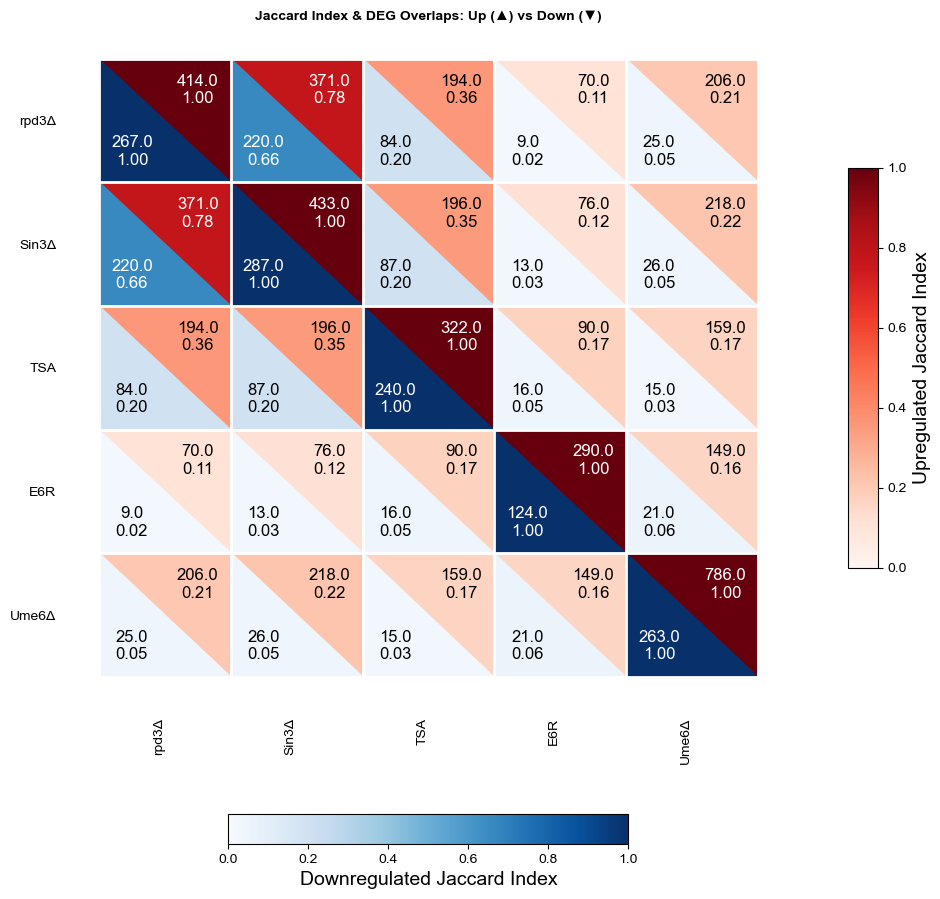

In [3]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#Specify the Arial paths manually, as matplotlib can't handle it by default 
FONT_PATHS = {
    'regular': "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    'bold': "/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf"
}


#Compute Jaccard matrix & extent of overlap 
def compute_jaccard_matrix(gene_sets):
    conditions = list(gene_sets.keys())
    overlap = pd.DataFrame(index=conditions, columns=conditions, dtype=int)
    jaccard = pd.DataFrame(index=conditions, columns=conditions, dtype=float)
    for c1 in conditions:
        for c2 in conditions:
            intersection = gene_sets[c1] & gene_sets[c2]
            union = gene_sets[c1] | gene_sets[c2]
            overlap.loc[c1, c2] = len(intersection)
            jaccard.loc[c1, c2] = len(intersection)/len(union) if union else 0.0
    return overlap, jaccard

def plot_split_diagonal_jaccard(up_overlap, up_jaccard, down_overlap, down_jaccard,
                                title, filename=None):
    labels = up_jaccard.index.tolist()
    n = len(labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.subplots_adjust(right=0.85, bottom=0.20)  #Shrink main plot for bars

    #Draw grid
    for i in range(n+1):
        ax.axhline(i, color='white', lw=2)
        ax.axvline(i, color='white', lw=2)
    
    #Draw cells
    for i in range(n):
        for j in range(n):
            x, y = j, i
            up_val = up_jaccard.iloc[i, j]
            down_val = down_jaccard.iloc[i, j]
            ax.add_patch(plt.Polygon(
                [[x, y], [x+1, y], [x+1, y+1]],
                color=plt.cm.Reds(up_val),
                edgecolor='white'
            ))
            ax.add_patch(plt.Polygon(
                [[x, y], [x, y+1], [x+1, y+1]],
                color=plt.cm.Blues(down_val),
                edgecolor='white'
            ))
            up_color = 'white' if up_val > 0.5 else 'black'
            down_color = 'white' if down_val > 0.5 else 'black'
            ax.text(x+0.75, y+0.25, 
                    f"{up_overlap.iloc[i,j]}\n{up_val:.2f}",
                    ha='center', va='center', 
                    fontsize=12,
                    color=up_color,
                    fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))
            ax.text(x+0.25, y+0.75, 
                    f"{down_overlap.iloc[i,j]}\n{down_val:.2f}",
                    ha='center', va='center',
                    fontsize=12,
                    color=down_color,
                    fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))

    #Axis formatting
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(n)+0.5)
    ax.set_xticklabels(labels, rotation=90, ha='right', fontsize=14,
                      fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))
    ax.set_yticklabels(labels, fontsize=14,
                      fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))
    ax.set_title(title, fontsize=18,
                 fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['bold']))
    ax.invert_yaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, left=False)

    # ======= Absolutely identical colorbars using inset_axes (inches) =======
    norm = Normalize(0, 1)
    ticks = np.linspace(0, 1, 6)
    bar_length = 4.0     #inches (adjust as desired)
    bar_thickness = 0.3  #inches (adjust as desired)

    #Vertical (right) colorbar for upregulated
    cax_up = inset_axes(ax, width=bar_thickness, height=bar_length, loc='center right',
                        bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    sm_red = ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm_red.set_array([])
    cbar_up = plt.colorbar(sm_red, cax=cax_up, orientation='vertical', ticks=ticks)
    cbar_up.set_label('Upregulated Jaccard Index', fontsize=14,
                      fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))
    cbar_up.ax.tick_params(labelsize=12, direction='out')
    for label in cbar_up.ax.get_yticklabels():
        label.set_fontproperties(mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))

    #Horizontal (bottom) colorbar for downregulated
    cax_down = inset_axes(ax, width=bar_length, height=bar_thickness, loc='lower center',
                          bbox_to_anchor=(0, -0.2, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    sm_blue = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm_blue.set_array([])
    cbar_down = plt.colorbar(sm_blue, cax=cax_down, orientation='horizontal', ticks=ticks)
    cbar_down.set_label('Downregulated Jaccard Index', fontsize=14,
                        fontproperties=mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))
    cbar_down.ax.tick_params(labelsize=12, direction='out')
    for label in cbar_down.ax.get_xticklabels():
        label.set_fontproperties(mpl.font_manager.FontProperties(fname=FONT_PATHS['regular']))

    if filename:
        plt.savefig(filename, dpi=300, transparent=True)
    return fig, ax

# =============================================================================
# Run on our DEG list 
# =============================================================================
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheets = pd.read_excel(excel_path, sheet_name=None)
up_sets = {}
down_sets = {}

for sheet_name, df in sheets.items():
    df = df[['Systematic Name', 'log2FoldChange']].dropna()
    up_sets[sheet_name] = set(df[df['log2FoldChange'] > 0]['Systematic Name'])
    down_sets[sheet_name] = set(df[df['log2FoldChange'] < 0]['Systematic Name'])
up_overlap, up_jaccard = compute_jaccard_matrix(up_sets)
down_overlap, down_jaccard = compute_jaccard_matrix(down_sets)

reorder = ['rpd3KO_DEGs', 'Sin3KO_DEGs', 'TSA_DEGs', 'E6R_DEGs', 'Ume6KO_DEGs']

label_map = {
    'rpd3KO_DEGs': 'rpd3Δ',
    'Sin3KO_DEGs': 'Sin3Δ',
    'TSA_DEGs': 'TSA',
    'E6R_DEGs': 'E6R',
    'Ume6KO_DEGs': 'Ume6Δ'
}

up_overlap = up_overlap.loc[reorder, reorder].rename(index=label_map, columns=label_map)
up_jaccard = up_jaccard.loc[reorder, reorder].rename(index=label_map, columns=label_map)
down_overlap = down_overlap.loc[reorder, reorder].rename(index=label_map, columns=label_map)
down_jaccard = down_jaccard.loc[reorder, reorder].rename(index=label_map, columns=label_map)

fig, ax = plot_split_diagonal_jaccard(
    up_overlap, up_jaccard,
    down_overlap, down_jaccard,
    title="Jaccard Index & DEG Overlaps: Up (▲) vs Down (▼)",
    filename="Figure4C_Final_Jaccard_Overlap_v3_13052025.pdf"
)

plt.show()
